Let's use datatset [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>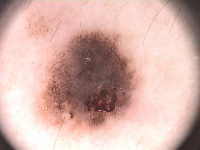</td><td>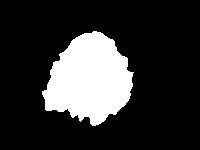</td></tr></table>

These are pictures of two types of **skin lesions:** melanoma and moles.

In this assignment we will not classify them, but will **segment** them.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2024-10-24 16:04:03--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70 [following]
--2024-10-24 16:04:03--  https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8b940e07e65ea8e797b6cdef55.dl.dropboxusercontent.com/cd/0/inline/CdF5iWBdEKYq4mICgUVBHBXOGCgtuNvTGFEG_p-tgsVPNkOipzeLFsqSLcPqCyCeSpnZK1V8tbqGGQrcCYGBnR3IZ5QNp_XejFRA8KazFgMSlPw1s_TJ_h9-R91I3HLRmEo/file# [following]
--2024-10-24 16:04:04--  https://uc8b940e07e65ea8e797b6cdef55.dl.dropboxusercontent.com/cd/0/inline/CdF5iWBdEKYq4mIC

Dataset Structure:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Here `X.bmp` is the image to be segmented, `X_lesion.bmp` is the result of the segmentation.

In [5]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Images have different sizes. Let's resize them to $256\times256 $ pixels. To resize images, you can use [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
This function also automatically normalizes images in the range $[0,1]$.


In [6]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [35]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [36]:
len(lesions)

200

#### Let's draw some images

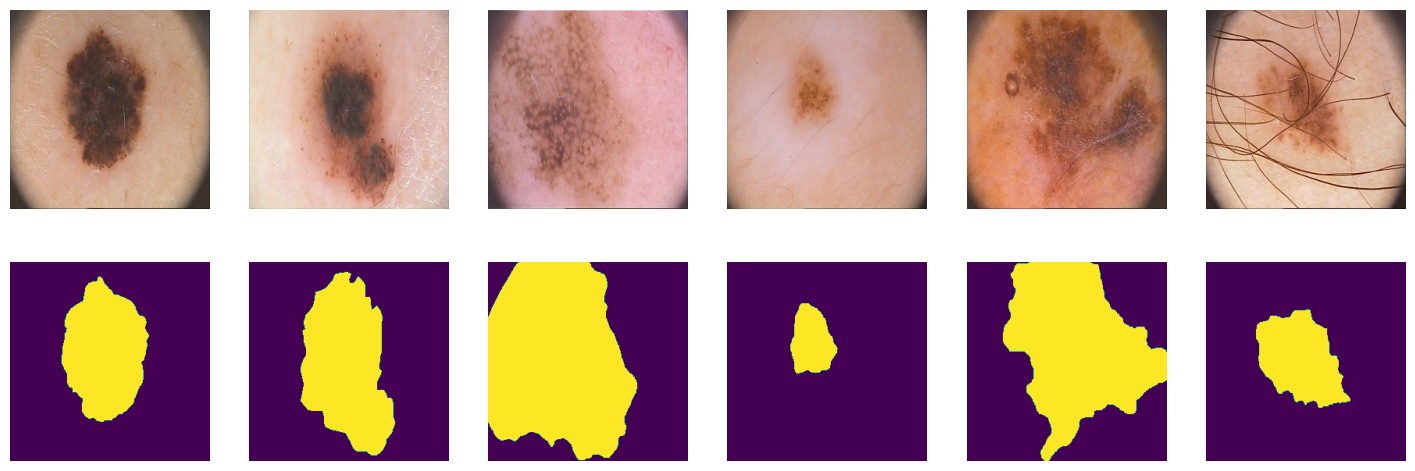

In [37]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i].astype(np.float32))

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i].astype(np.float32))
plt.show();

#### Split Data to train/val/test

In [38]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [39]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [40]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True, pin_memory=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True, pin_memory=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True, pin_memory=True)

In [41]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# SegNet

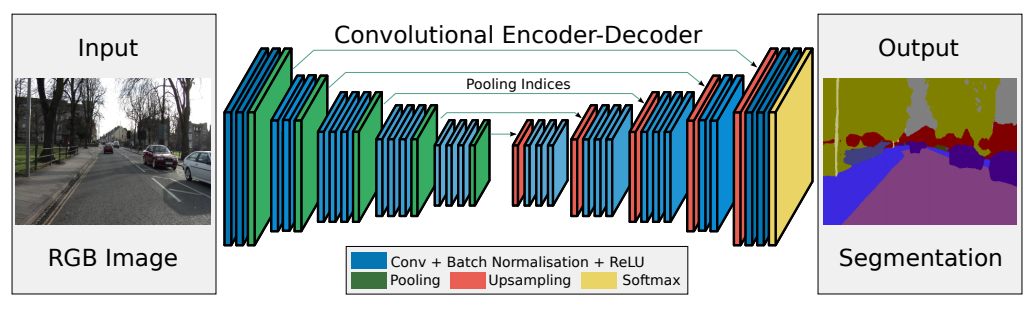

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [208]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [209]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, kernel_s = 3, pad = 1):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=kernel_s, padding=pad)
        self.bn = nn.BatchNorm2d(out_c)
        self.act = nn.ReLU()


    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.act(x)

In [342]:
class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, num = 2, kernel_s = 3, pad = 1):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num):
            if i == 0:
                self.layers.append(ConvBlock(in_c, out_c, kernel_s, pad))
            else:
                self.layers.append(ConvBlock(out_c, out_c, kernel_s, pad))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [343]:
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c, num = 2, kernel_s = 3, pad = 1, output = False):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num):
            if i == num - 1 and output:
                self.layers.append(nn.Conv2d(in_c, out_c, kernel_size=kernel_s, padding=pad))
            elif i == num - 1:
                self.layers.append(ConvBlock(in_c, out_c, kernel_s, pad))
            else:
                self.layers.append(ConvBlock(in_c, in_c, kernel_s, pad))


    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = EncoderBlock(3, 6)
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)
        self.enc_conv1 = EncoderBlock(6, 12)
        self.pool1 =  nn.MaxPool2d((2, 2), 2, return_indices=True)
        self.enc_conv2 = EncoderBlock(12, 24, num = 3)
        self.pool2 = nn.MaxPool2d((2, 2), 2, return_indices=True)
        self.enc_conv3 = EncoderBlock(24, 48, num = 3)
        self.pool3 = nn.MaxPool2d((2, 2), 2, return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(48, 48, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(2, 2)
        self.dec_conv0 = DecoderBlock(48, 24)
        self.upsample1 =  nn.MaxUnpool2d(2, 2)
        self.dec_conv1 = DecoderBlock(24, 12)
        self.upsample2 =  nn.MaxUnpool2d(2, 2)
        self.dec_conv2 = DecoderBlock(12, 6)
        self.upsample3 =  nn.MaxUnpool2d(2, 2)
        self.dec_conv3 = DecoderBlock(6, 1, output=True)

    def forward(self, x):
        # encoder
        x, idx0 = self.pool0(self.enc_conv0(x))
        x, idx1 = self.pool1(self.enc_conv1(x))
        x, idx2 = self.pool2(self.enc_conv2(x))
        x, idx3 = self.pool3(self.enc_conv3(x))

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.dec_conv0(self.upsample0(x, idx3))
        x = self.dec_conv1(self.upsample1(x, idx2))
        x = self.dec_conv2(self.upsample2(x, idx1))
        x = self.dec_conv3(self.upsample3(x, idx0))
        x = torch.nn.functional.sigmoid(x)
        return x

## Metrics

In this section, the following metric is proposed for quality assessment:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

The intersection (A ∩ B) consists of pixels found in both the prediction mask and the main truth mask, whereas the union (A ∪ B) simply consists of all pixels found in either the prediction mask or the target mask.


For an example, let's look at truth (left) and prediction (right):

![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Then the intersection and union will look like this:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded

## Loss function

Just as important as building the architecture is defining the **optimizer** and **loss function.**

A popular method for binary segmentation is *binary cross-entropy*, which is defined as follows:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ is the target of the desired outcome and $\hat y$ is the output of the model. $\sigma$ is a [*logistic* function](https://en.wikipedia.org/wiki/Sigmoid_function) that converts a real number $\mathbb R$ into a probability $[0,1]$.

However, this loss suffers from numerical instability problems. Most importantly, $\lim_{x\rightarrow0}\log(x)=\infty$ leads to instability in the optimization process. It is recommended to look at the following [simplification](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). This function is equivalent to the first one and is not as prone to numerical instability:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [346]:
bce_loss = torch.nn.BCEWithLogitsLoss()

In [347]:
def bce_loss(y_real, y_pred):
    return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-(y_pred).abs()))).sum()

## Inference

Once the model is trained, this feature can be used to predict segmentation on new data:

In [348]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [349]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device)).round()
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores / len(data)

## Training

We will define a learning loop in the function so that we can reuse it.

In [350]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, device, iou_pytorch):
    train_loss_hist = []
    acc_val_hist = []
    acc_train_hist = []
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        loss = 0
        avg_loss = 0
        model.train()  # train mode
        opt.zero_grad()
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            Y_pred = model(X_batch)
            loss +=  loss_fn(Y_batch, Y_pred)
            avg_loss += loss.detach().cpu().item() / len(data_tr)

        loss.backward()
        opt.step()
        toc = time()
        
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu()
        acc_val = score_model(model, iou_pytorch, data_val)
        train_loss_hist.append(loss.detach().cpu().item())
        acc_val_hist.append(acc_val)
        acc_train_hist.append(score_model(model, iou_pytorch, data_tr))
        print(f"Val acc: {acc_val}")
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return train_loss_hist, acc_val_hist, acc_train_hist

## Key point: learning

Train your model. Note that it is necessary to train until convergence. If the specified number of epochs (20) is not enough, try to change the number of epochs until the algorithm converges. Determine convergence by the change of the loss function on the validation sample.
You can safely play with the optimizer parameters until you find the best option for you.

In [351]:
model = torch.nn.DataParallel(SegNet(), device_ids = [0,1]).to(device)

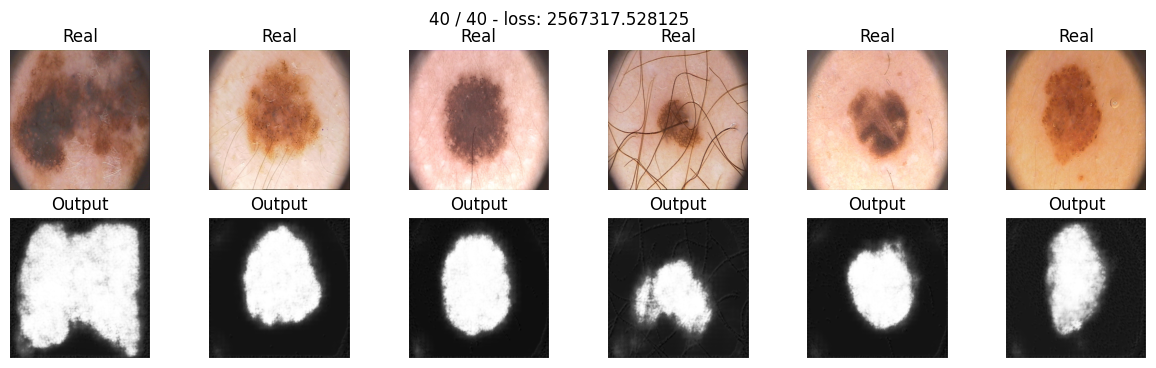

In [353]:
max_epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, amsgrad=True)
seg_bce_tr_loss, seg_bce_val_hist, seg_bce_train_hist = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val, device, iou_pytorch)

In [354]:
score_model(model, iou_pytorch, data_ts)

0.6040000438690185

#### As we can see model don't start overfitting

## Additional loss functions

 In this section, we implement two loss functions:
 DICE and Focal loss.

**1. Dice coefficient:** Given two masks $X$ and $Y$, the general metric for measuring the distance between these two masks is given as follows:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

This function is not differentiable, but it is a necessary property for gradient descent. In this case we can approximate it with:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Let's also think about numerical stability in mathematical formulas

In [280]:
def dice_loss(y_real, y_pred):
    eps = 1e-8
    num = 2 * (y_real * y_pred).sum() + eps
    den = (y_real + y_pred).sum() + eps
    res = num / den
    return 256 ** 2 - res

#### Let's test

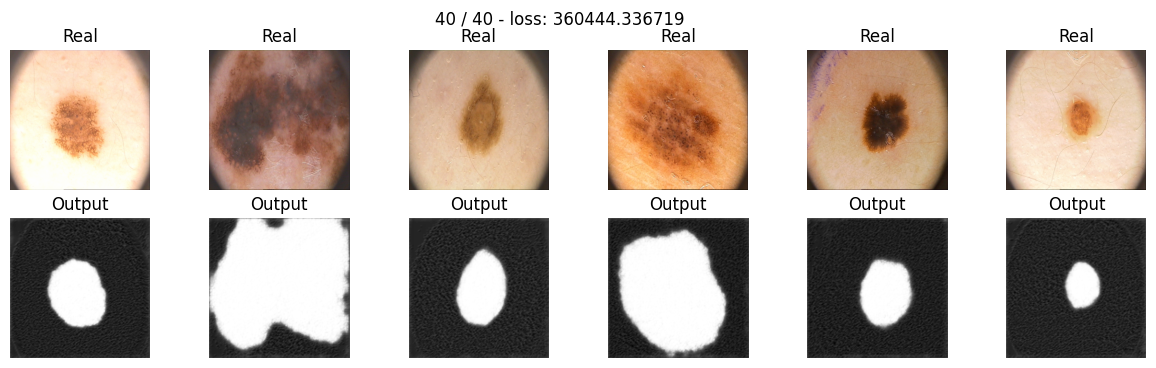

In [281]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters(), lr=3e-3)
seg_dice_tr_loss, seg_dice_val_hist, seg_dice_train_hist = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, device, iou_pytorch)

In [282]:
score_model(model_dice, iou_pytorch, data_val)

0.6180000305175781

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

We are already know how to do BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

The problem with this loss is that it tends to favor the **majority** (background) class over the **majority** ( front) class. Therefore, weights are usually applied to each class:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Traditionally, the weight $\alpha_i$ is defined as the inverse of the frequency of that pixel's class $i$, so that observations of the minority class weigh more relative to the majority class.

Another recent addition is the weighted pixel variant, which weights each pixel by the degree of confidence we have in predicting that pixel.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Let's fix the value $\gamma=2$.

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    return -((1 - y_pred) ** gamma * y_real * y_pred.log() + (1 - y_real) * (1 - y_pred).log()).sum()

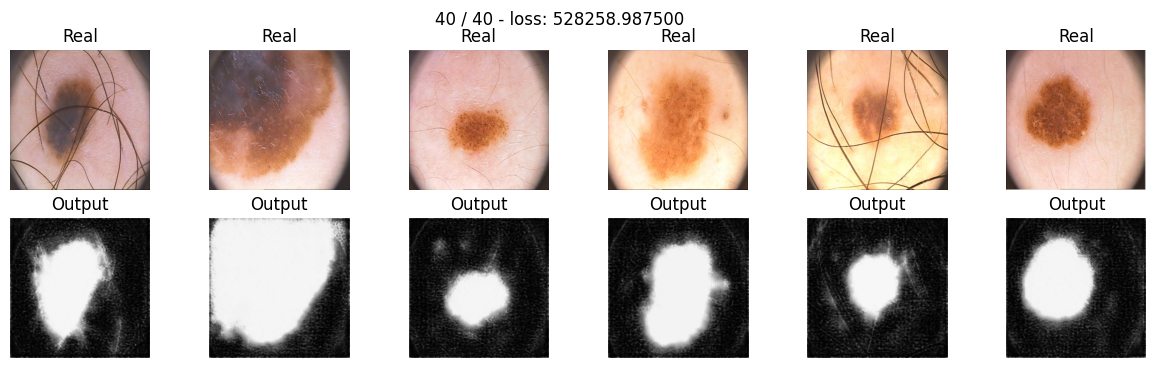

In [284]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters(), lr=3e-3, amsgrad=True)
seg_focal_tr_loss, seg_focal_val_hist, seg_focal_train_hist = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, device, iou_pytorch)

In [286]:
score_model(model_focal, iou_pytorch, data_val)

0.7080000162124633

#### Let's implement Total variation Loss

In [287]:
def customLoss(y_real, y_pred):
    eps = 1e-8
    y_norm = y_real - y_real.mean()
    x_norm = y_pred - y_pred.mean()
    Lssim = torch.norm(x_norm - y_norm) / (torch.norm(x_norm) + torch.norm(y_pred) + (y_real.shape[0] - 1) * eps) / y_real.shape[0]
    return Lssim

In [300]:
model_custom = SegNet().to(device)

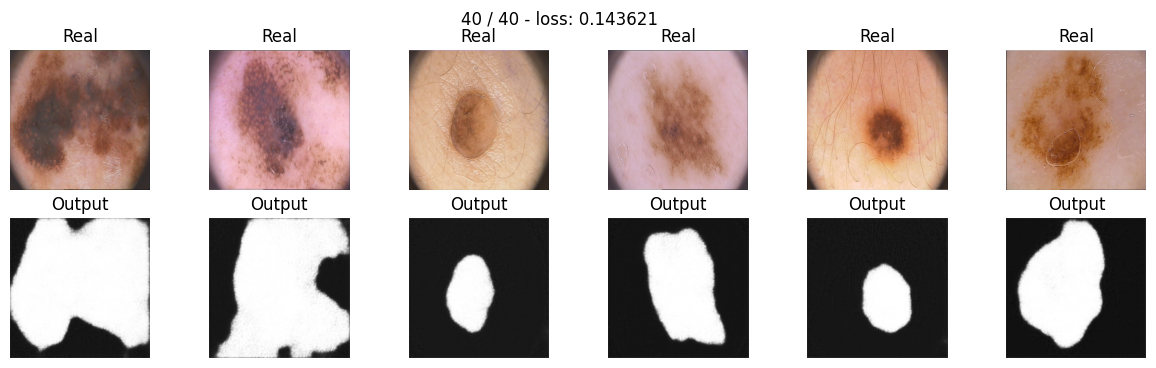

In [302]:
max_epochs = 40
optimaizer = optim.Adam(model_custom.parameters(), lr=1e-3, amsgrad=True)
seg_custom_tr_loss, seg_custom_val_hist, seg_custom_train_hist = train(model_custom, optimaizer, customLoss, max_epochs, data_tr, data_val, device, iou_pytorch)

In [303]:
score_model(model_custom, iou_pytorch, data_val)

0.6880000233650208

# U-Net

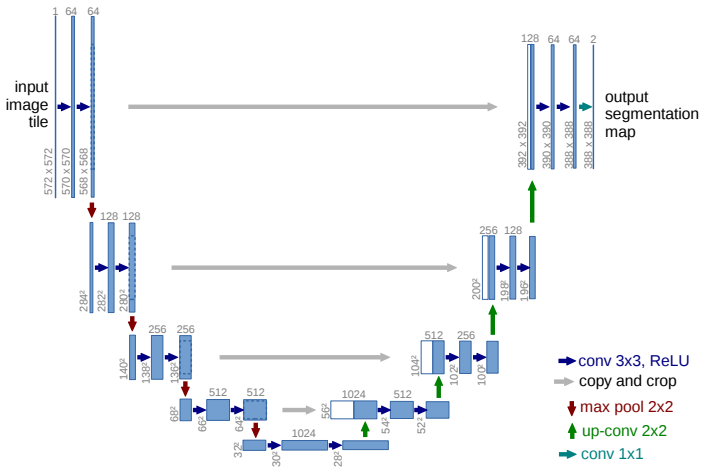

In [304]:
class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, num = 2):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num):
            if i == 0:
                self.layers.append(nn.Conv2d(in_c, out_c, kernel_size = 3, padding = 1))
            else:
                self.layers.append(nn.Conv2d(out_c, out_c, kernel_size = 3, padding = 1))
            self.layers.append(nn.BatchNorm2d(out_c))
            self.layers.append(nn.ReLU(inplace=True))


    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [305]:
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c, num = 2):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num):
            if i == 0:
                self.layers.append(nn.Conv2d(in_c, out_c, kernel_size = 3, padding = 1))
            else:
                self.layers.append(nn.Conv2d(out_c, out_c, kernel_size = 3, padding = 1))
            self.layers.append(nn.BatchNorm2d(out_c))
            self.layers.append(nn.ReLU(inplace=True))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.enc_conv0 = EncoderBlock(3, 16)
        self.pool0 = nn.MaxPool2d(2, 2)
        self.enc_conv1 = EncoderBlock(16, 32)
        self.pool1 =  nn.MaxPool2d(2, 2)
        self.enc_conv2 = EncoderBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc_conv3 = EncoderBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2, 2)

        # bottleneck
        self.bottleneck_conv = EncoderBlock(128, 256)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(256, 128, kernel_size = (2, 2), stride = 2)
        self.dec_conv0 = DecoderBlock(256, 128)
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size = (2, 2), stride = 2)
        self.dec_conv1 = DecoderBlock(128, 64)
        self.upsample2 = nn.ConvTranspose2d(64, 32, kernel_size = (2, 2), stride = 2)
        self.dec_conv2 = DecoderBlock(64, 32)
        self.upsample3 = nn.ConvTranspose2d(32, 16, kernel_size = (2, 2), stride = 2)
        self.dec_conv3 = DecoderBlock(32, 16)

        self.out = nn.Conv2d(16, 1, kernel_size= 1)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        x = self.pool0(e0)
        e1 = self.enc_conv1(x)
        x = self.pool1(e1)
        e2 = self.enc_conv2(x)
        x = self.pool2(e2)
        e3 = self.enc_conv3(x)
        x = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(x)

        # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b), e3], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), e2], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e1], 1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], 1))
        
        return torch.nn.functional.sigmoid(self.out(d3))

In [319]:
unet_model = UNet().to(device)

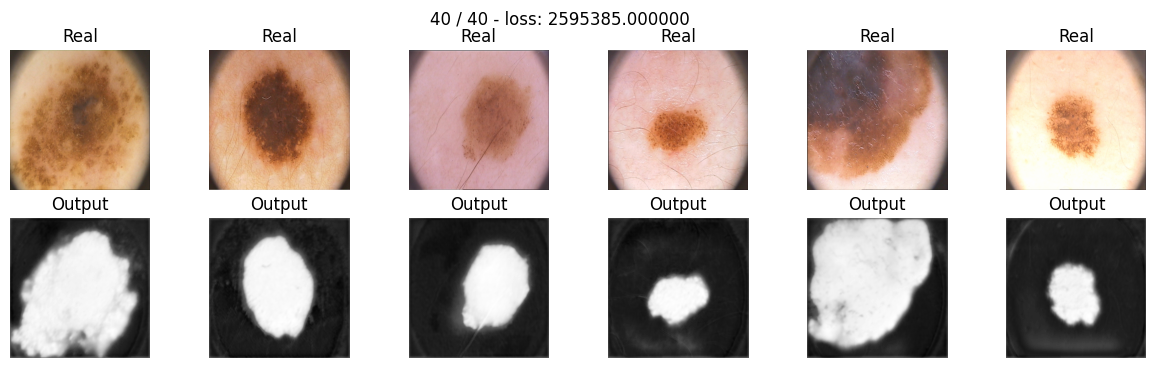

In [320]:
unet1_tr_loss, unet1_val_hist, unet1_train_hist = train(unet_model, optim.Adam(unet_model.parameters(), lr=1e-3, amsgrad=True), bce_loss, 40, data_tr, data_val, device, iou_pytorch)

In [321]:
score_model(unet_model, iou_pytorch, data_val)

0.7400000214576721

New model by changing the type of pooling:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.enc_conv0 = EncoderBlock(3, 16)
        self.pool0 = nn.Conv2d(16, 16, 1, stride = 2)
        self.enc_conv1 = EncoderBlock(16, 32)
        self.pool1 = nn.Conv2d(32, 32, 1, stride = 2)
        self.enc_conv2 = EncoderBlock(32, 64)
        self.pool2 = nn.Conv2d(64,64, 1, stride = 2)
        self.enc_conv3 = EncoderBlock(64, 128)
        self.pool3 = nn.Conv2d(128,128, 1, stride = 2)

        # bottleneck
        self.bottleneck_conv = EncoderBlock(128, 256)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(256, 128, kernel_size = (2, 2), stride = 2)
        self.dec_conv0 = DecoderBlock(256, 128)
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size = (2, 2), stride = 2)
        self.dec_conv1 = DecoderBlock(128, 64)
        self.upsample2 = nn.ConvTranspose2d(64, 32, kernel_size = (2, 2), stride = 2)
        self.dec_conv2 = DecoderBlock(64, 32)
        self.upsample3 = nn.ConvTranspose2d(32, 16, kernel_size = (2, 2), stride = 2)
        self.dec_conv3 = DecoderBlock(32, 16)

        self.out = nn.Conv2d(16, 1, kernel_size= 1)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        x = self.pool0(e0)
        e1 = self.enc_conv1(x)
        x = self.pool1(e1)
        e2 = self.enc_conv2(x)
        x = self.pool2(e2)
        e3 = self.enc_conv3(x)
        x = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(x)

        # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b), e3], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), e2], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e1], 1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], 1))
        
        return torch.nn.functional.sigmoid(self.out(d3))

In [323]:
gc.collect()

torch.cuda.empty_cache()

In [325]:
unet2_model = torch.nn.DataParallel(UNet2(), device_ids = [0,1]).to(device)

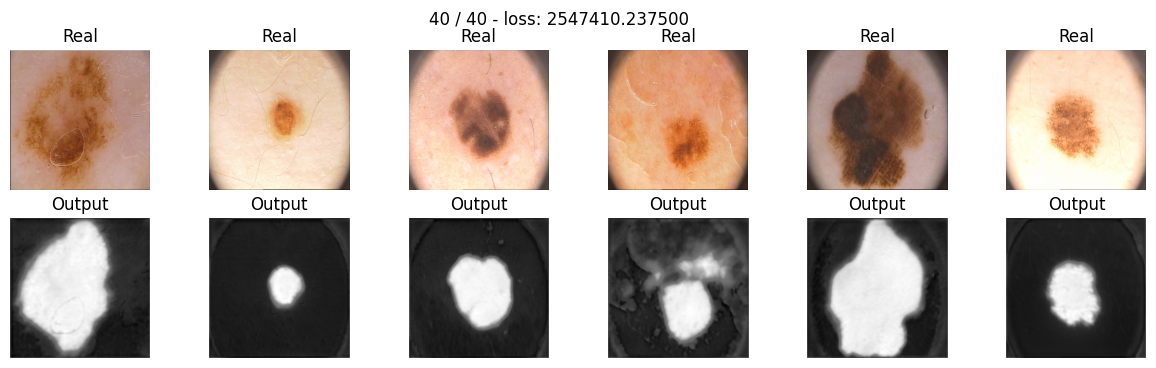

In [327]:
unet2_tr_loss, unet2_val_hist, unet2_train_hist = train(unet2_model, optim.Adam(unet2_model.parameters(), lr=1e-3, amsgrad=True), bce_loss, 40, data_tr, data_val, device, iou_pytorch)

In [328]:
score_model(unet2_model, iou_pytorch, data_val)

0.7500000238418579

#### Of the Unet, the model with MaxPool replaced by a convolution layer performed best because of the customizable parameters on each channel separately

In [358]:
seq_loss = [
    seg_bce_tr_loss, seg_dice_tr_loss, seg_focal_tr_loss, seg_custom_tr_loss
]

seq_acc_val = [
    seg_bce_val_hist, seg_dice_val_hist, seg_focal_val_hist, seg_custom_val_hist
]

seq_acc_tr = [
    seg_bce_train_hist, seg_dice_train_hist, seg_focal_train_hist, seg_custom_train_hist
]

In [359]:
unet_loss = [
    unet1_tr_loss, unet2_tr_loss
]

unet_acc_val = [
    unet1_val_hist, unet2_val_hist
]

unet_acc_tr = [
    unet1_train_hist, unet2_train_hist
]

#### First let's compare the different Loss functions for SegNet

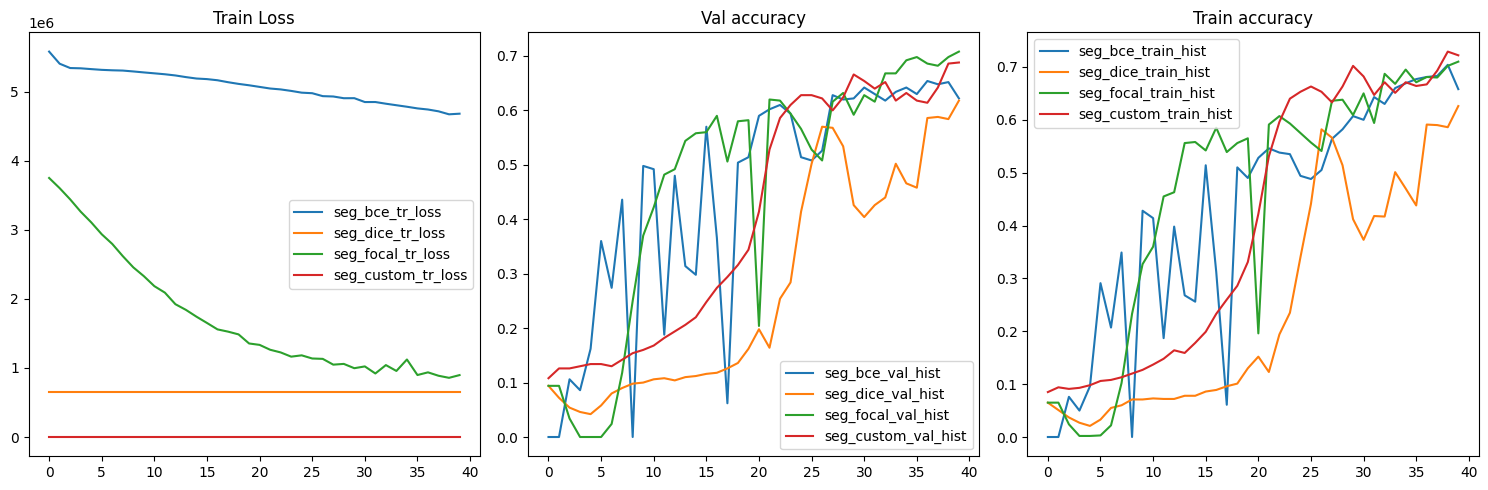

In [411]:
loss_names = ["seg_bce_tr_loss", "seg_dice_tr_loss", "seg_focal_tr_loss", "seg_custom_tr_loss"]
acc_val_names = ["seg_bce_val_hist", "seg_dice_val_hist", "seg_focal_val_hist", "seg_custom_val_hist"]
acc_train_names = ["seg_bce_train_hist", "seg_dice_train_hist", "seg_focal_train_hist", "seg_custom_train_hist"]

titles = ['Train Loss', 'Val accuracy', 'Train accuracy']


name_dict = {0 : loss_names, 1 : acc_val_names, 2 : acc_train_names}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, data in enumerate([seq_loss, seq_acc_val, seq_acc_tr]):
    axs[i].plot(np.array(data).T, label=name_dict[i])
    axs[i].set_title(titles[i])
    axs[i].legend()

plt.tight_layout()
fig.show()

As you can see from the graphs, BCE and DICE turned out to be quite noisy, which can't be said about focal and custom loess, with custom loess showing the best results and its graph being the smoothest

#### Now let's look at two UNet models

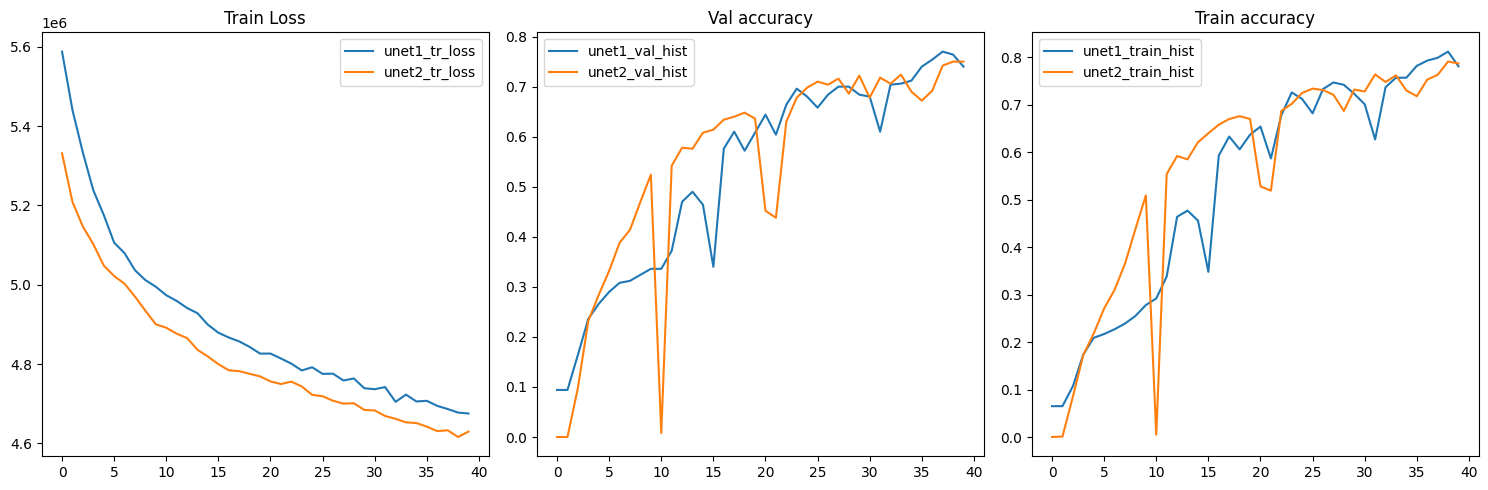

In [412]:
loss_names = ["unet1_tr_loss", "unet2_tr_loss"]
acc_val_names = ["unet1_val_hist", "unet2_val_hist"]
acc_train_names = ["unet1_train_hist", "unet2_train_hist"]

titles = ['Train Loss', 'Val accuracy', 'Train accuracy']


name_dict = {0 : loss_names, 1 : acc_val_names, 2 : acc_train_names}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, data in enumerate([unet_loss, unet_acc_val, unet_acc_tr]):
    axs[i].plot(np.array(data).T, label=name_dict[i])
    axs[i].set_title(titles[i])
    axs[i].legend()

plt.tight_layout()
fig.show()

Based on accuracy, the models are almost identical, with the graph of the second version being smoother towards the end, but the loss graph puts everything in its place and it can be seen that Unet2 was trained better.

It is also worth noting that UNet itself showed better results than SegNet, because the Unet architecture itself was created for accurate segmentation in the field of medicine, which made it much more accurate and better than SegNet.